# Compression Analysis (Deprecated from early 2023.)

Andrei's analysis on the impact of various compression parameters on file size, compression time, and PSNR.

If time allows it, I will also look into decompression time but it's not high priority for now.

## Dataset

I sampled 2,500 images from the pre-release Pit30M data, compressed **losslessly** with WebP. The images are sampled at random from 25 different driving logs and 7 cameras, covering urban areas, parks, traffic, etc., as well as a variety of weather and driving condition.

The average image size is 2183KiB, computed with this handy one-liner:

```bash
find $DATASET_DIR -iname '*.webp' -exec ls -la '{}' + | \
    awk '{ total_b+=$5; count+=1 } END { print total_b/count/1024 }' 
```

Given that this covers people*, cars*, trees, buildings, roads, etc. as seen from different view points and focal length, it should give us pretty good signal.

*) In the final dataset release, faces and license plates were blurred to preserve privacy.

In [2]:
import io
import os
import random
import sys
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage.metrics as skm
from joblib import Parallel, delayed, Memory
from tqdm import tqdm
from PIL import Image

# Required for AVIF support in PILLOW
import pillow_avif

%matplotlib inline

memory = Memory(location="/tmp/compression-experiment-pit30m")

print(sys.version_info)
print(sys.executable)

sys.version_info(major=3, minor=11, micro=0, releaselevel='final', serial=0)
/home/andrei/miniconda3/envs/dl311v0/bin/python


In [2]:
DATASET_DIR = Path("~/work/pit30m/out/size_analysis").expanduser()
# Limit the number of images to make the computation complete on time
#
# Especially SSIM computation is slow with the skimage implementation
MAX_IMG = 2500

random.seed(123)
image_fpaths = sorted(list(DATASET_DIR.glob("**/*.webp")))
random.shuffle(image_fpaths)
image_fpaths = image_fpaths[:MAX_IMG]
print(len(image_fpaths))

2500


In [8]:
# all_images = [(fpath, Image.open(fpath)) for fpath in image_fpaths]

In [ ]:
# Default in scikit-image and in libvmaf, which means it's likely a reasonable default.
# ffmpeg uses 8x8 windows, so close to this too. See: https://arxiv.org/pdf/2101.06354.pdf
ssim_win_size = 11

@memory.cache()
def run_configuration(all_images, format, quality, method):
    # NOTE: For webm 'method = 4' is the default, with lower being faster

    fpaths = []
    encode_times = []
    decode_times = []
    psnrs = []
    ssims = []
    sizes_b = []

    for fpath in tqdm(all_images, postfix=f"{format} q={quality} m={method}"):
        image = Image.open(fpath)
        
        with io.BytesIO() as f:
            start_ts = time.time()
            if format == "webp":
                image.save(f, format=format, quality=quality, method=method)
            else:
                # JPEG does not have 'method' to tweak encoding speed.
                image.save(f, format=format, quality=quality)
            encode_time = time.time() - start_ts
            encode_times.append(encode_time)
            n_bytes = len(f.getbuffer())

            f.seek(0)
            decode_start_ts = time.time()
            reloaded_compressed_np = np.asarray(Image.open(f))
            decode_time = time.time() - decode_start_ts
            decode_times.append(decode_time)
            original_np = np.asarray(image)
            psnr_db = skm.peak_signal_noise_ratio(original_np, reloaded_compressed_np)
#             print(original_np.shape)
#             print(reloaded_compressed_np.shape)
            # NOTE(andrei): SSIM right now is a bit slow...
            ssim = skm.structural_similarity(original_np, reloaded_compressed_np, 
                                             win_size=ssim_win_size, channel_axis=2)
#             ssim = -1

            fpaths.append(fpath)
            sizes_b.append(n_bytes)
            psnrs.append(psnr_db)
            ssims.append(ssim)

#             plt.figure(figsize=(20, 8))
#             plt.imshow(reloaded_compressed_np)

    return fpaths, encode_times, decode_times, psnrs, ssims, sizes_b

configs = []
for format in ["jpeg", "webp"]:
    for quality in [65, 70, 75, 80, 85, 90, 95, 100]:
        meths = [-1] if format == "jpeg" else [0, 1, 2, 3, 4, 5, 6]
        for method in meths:
            configs.append((format, quality, method))
 

# Run the main experiment multithreaded, then do the timing analysis separately, or reload the
# older experiment you ran single-threaded. We mostly care about the SSIM for this parallelized run,
# since SSIM is slow AF to compute.
pool = Parallel(n_jobs=8)
results = pool(delayed(run_configuration)(image_fpaths, format, quality, method)
               for format, quality, method in configs)
# results[(format, quality, method)] = \
#                 run_configuration(image_fpaths, format=format,
#                                   quality=quality, method=method)

________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'jpeg', 65, -1)
________________________________________________________________________________
[Memory] Calling __main__

 99%|█████████▉| 2479/2500 [1:03:22<00:31,  1.51s/it, jpeg q=85 m=-1]]

____________________________________________run_configuration - 3801.9s, 63.4min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 65, 0)


100%|█████████▉| 2491/2500 [1:03:22<00:12,  1.44s/it, jpeg q=80 m=-1]

____________________________________________run_configuration - 3802.8s, 63.4min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 65, 1)


100%|█████████▉| 2494/2500 [1:03:26<00:08,  1.44s/it, jpeg q=80 m=-1]]

____________________________________________run_configuration - 3807.0s, 63.5min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 65, 2)


 99%|█████████▉| 2481/2500 [1:03:36<00:28,  1.48s/it, jpeg q=90 m=-1]

____________________________________________run_configuration - 3816.5s, 63.6min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 65, 3)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=65 m=4]p q=65 m=2]=-1]

____________________________________________run_configuration - 3833.8s, 63.9min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 65, 4)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=65 m=5]q=65 m=2]  

____________________________________________run_configuration - 3845.5s, 64.1min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 65, 5)


  1%|          | 29/2500 [00:44<1:03:10,  1.53s/it, webp q=65 m=3]=-1]

____________________________________________run_configuration - 3857.4s, 64.3min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 65, 6)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=70 m=0]p q=65 m=4]

____________________________________________run_configuration - 3948.7s, 65.8min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 70, 0)


 97%|█████████▋| 2436/2500 [1:00:26<01:33,  1.47s/it, webp q=65 m=0]

____________________________________________run_configuration - 3625.8s, 60.4min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 70, 1)


 97%|█████████▋| 2433/2500 [58:53<01:37,  1.45s/it, webp q=70 m=0]6]

____________________________________________run_configuration - 3674.6s, 61.2min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 70, 2)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=70 m=3]p q=70 m=2]

____________________________________________run_configuration - 3722.1s, 62.0min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 70, 3)


 87%|████████▋ | 2177/2500 [1:02:02<08:56,  1.66s/it, webp q=65 m=6]

____________________________________________run_configuration - 3631.0s, 60.5min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 70, 4)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=70 m=5] q=70 m=2]]4]

____________________________________________run_configuration - 3892.4s, 64.9min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 70, 5)


 96%|█████████▋| 2409/2500 [1:04:39<02:19,  1.54s/it, webp q=65 m=4]

____________________________________________run_configuration - 3867.7s, 64.5min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 70, 6)


  8%|▊         | 212/2500 [05:32<59:52,  1.57s/it, webp q=70 m=3]

____________________________________________run_configuration - 4022.7s, 67.0min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 75, 0)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=75 m=1] q=70 m=2]

____________________________________________run_configuration - 4264.6s, 71.1min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 75, 1)


 78%|███████▊  | 1960/2500 [48:42<13:04,  1.45s/it, webp q=75 m=1]

____________________________________________run_configuration - 3615.4s, 60.3min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 75, 2)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=75 m=3]p q=70 m=6]

____________________________________________run_configuration - 3629.2s, 60.5min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 75, 3)


100%|██████████| 2500/2500 [1:04:26<00:00,  1.55s/it, webp q=70 m=4]


____________________________________________run_configuration - 3866.6s, 64.4min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 75, 4)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=75 m=5]p q=75 m=1]0]

____________________________________________run_configuration - 3978.7s, 66.3min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 75, 5)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=75 m=6]p q=75 m=5]

____________________________________________run_configuration - 3749.5s, 62.5min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 75, 6)


100%|██████████| 2500/2500 [1:05:31<00:00,  1.57s/it, webp q=70 m=5]


____________________________________________run_configuration - 3931.8s, 65.5min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 80, 0)


  5%|▍         | 118/2500 [03:21<1:08:16,  1.72s/it, webp q=75 m=6]]

____________________________________________run_configuration - 4094.3s, 68.2min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 80, 1)


  5%|▌         | 125/2500 [02:58<56:12,  1.42s/it, webp q=80 m=0]5]

____________________________________________run_configuration - 3696.9s, 61.6min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 80, 2)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=80 m=3]p q=80 m=1]3]

____________________________________________run_configuration - 3673.4s, 61.2min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 80, 3)


 91%|█████████ | 2268/2500 [58:35<06:06,  1.58s/it, webp q=75 m=4]

____________________________________________run_configuration - 3851.0s, 64.2min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 80, 4)


 96%|█████████▌| 2403/2500 [57:48<02:17,  1.41s/it, webp q=80 m=1]5]

____________________________________________run_configuration - 3634.8s, 60.6min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 80, 5)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=80 m=6]p q=80 m=5]6]

____________________________________________run_configuration - 3872.8s, 64.5min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 80, 6)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=85 m=0] q=80 m=3]]5]

____________________________________________run_configuration - 3606.6s, 60.1min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 85, 0)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=85 m=1] q=80 m=5]=6]

____________________________________________run_configuration - 3669.8s, 61.2min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 85, 1)


 20%|██        | 510/2500 [13:04<49:44,  1.50s/it, webp q=80 m=3]=6]

____________________________________________run_configuration - 3999.4s, 66.7min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 85, 2)


 16%|█▋        | 409/2500 [10:33<53:47,  1.54s/it, webp q=80 m=5]

____________________________________________run_configuration - 4302.7s, 71.7min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 85, 3)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=85 m=4]p q=80 m=6]

____________________________________________run_configuration - 3838.9s, 64.0min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 85, 4)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=85 m=5]bp q=85 m=4]

____________________________________________run_configuration - 3828.9s, 63.8min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 85, 5)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=85 m=6]ebp q=80 m=5]

____________________________________________run_configuration - 3548.3s, 59.1min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 85, 6)


 97%|█████████▋| 2421/2500 [1:03:12<02:01,  1.54s/it, webp q=80 m=5]

____________________________________________run_configuration - 3579.2s, 59.7min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 90, 0)


 98%|█████████▊| 2462/2500 [1:01:27<00:55,  1.45s/it, webp q=85 m=2]

____________________________________________run_configuration - 3914.0s, 65.2min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 90, 1)


  2%|▏         | 38/2500 [00:55<58:54,  1.44s/it, webp q=90 m=1]]

____________________________________________run_configuration - 3742.6s, 62.4min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 90, 2)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=90 m=3] q=85 m=6]  ]

____________________________________________run_configuration - 4191.8s, 69.9min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 90, 3)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=90 m=4] q=90 m=0]

____________________________________________run_configuration - 3946.9s, 65.8min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 90, 4)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=90 m=5]p q=90 m=3]

____________________________________________run_configuration - 3831.4s, 63.9min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 90, 5)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=90 m=6]

____________________________________________run_configuration - 3858.2s, 64.3min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 90, 6)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=95 m=0]

____________________________________________run_configuration - 3581.1s, 59.7min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 95, 0)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=95 m=1]p q=90 m=3]]

____________________________________________run_configuration - 3679.2s, 61.3min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 95, 1)


  3%|▎         | 75/2500 [01:49<58:39,  1.45s/it, webp q=95 m=1]=6]

____________________________________________run_configuration - 3733.8s, 62.2min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 95, 2)


100%|██████████| 2500/2500 [1:10:36<00:00,  1.69s/it, webp q=85 m=6]


____________________________________________run_configuration - 4236.4s, 70.6min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 95, 3)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=95 m=4]bp q=95 m=3]

____________________________________________run_configuration - 3860.5s, 64.3min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 95, 4)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=95 m=5] q=90 m=5]

____________________________________________run_configuration - 3863.6s, 64.4min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 95, 5)


 91%|█████████▏| 2282/2500 [55:44<05:17,  1.45s/it, webp q=95 m=1]

____________________________________________run_configuration - 3563.6s, 59.4min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 95, 6)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=100 m=0] q=95 m=2]

____________________________________________run_configuration - 3845.1s, 64.1min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 100, 0)


 81%|████████  | 2029/2500 [52:34<12:00,  1.53s/it, webp q=95 m=4]

____________________________________________run_configuration - 3657.5s, 61.0min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 100, 1)


 89%|████████▉ | 2223/2500 [57:04<06:46,  1.47s/it, webp q=95 m=3]]

____________________________________________run_configuration - 3645.0s, 60.8min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 100, 2)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=100 m=3] q=95 m=5]

____________________________________________run_configuration - 4323.4s, 72.1min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 100, 3)


 14%|█▍        | 353/2500 [08:34<51:37,  1.44s/it, webp q=100 m=1]]

____________________________________________run_configuration - 3842.1s, 64.0min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 100, 4)


  0%|          | 0/2500 [00:00<?, ?it/s, webp q=100 m=5]p q=100 m=4]

____________________________________________run_configuration - 3869.9s, 64.5min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 100, 5)


 40%|███▉      | 993/2500 [23:12<34:27,  1.37s/it, webp q=100 m=0]

____________________________________________run_configuration - 3906.3s, 65.1min
________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-3732551948.run_configuration...
run_configuration([ PosixPath('/home/andrei/work/pit30m/out/size_analysis/f81c4def-1e47-4b83-cff8-3a8d2f9e5538/hdcam_10_port_front_roof_wide/0013469.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0003797.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/46d5d171-8471-441a-e67e-3d434949f8ea/hdcam_12_middle_front_roof_narrow_right/0022236.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/9dd6c8d1-1461-459c-e2b8-92682ab1807e/hdcam_08_port_rear_roof_wide/0010315.webp'),
  PosixPath('/home/andrei/work/pit30m/out/size_analysis/4644d0d4-c4c9-4dad-dbaf-b66c4932178c/hdcam_12_middle_front_roof_wide/0000167...., 
'webp', 100, 6)


 98%|█████████▊| 2452/2500 [57:38<00:56,  1.19s/it, webp q=100 m=1]]

____________________________________________run_configuration - 3452.1s, 57.5min


 95%|█████████▌| 2386/2500 [56:10<01:40,  1.14it/s, webp q=100 m=3]]

____________________________________________run_configuration - 3516.6s, 58.6min


 62%|██████▏   | 1546/2500 [45:59<21:39,  1.36s/it, webp q=100 m=6]]

____________________________________________run_configuration - 3461.6s, 57.7min


 76%|███████▌  | 1894/2500 [51:59<09:29,  1.06it/s, webp q=100 m=6]

____________________________________________run_configuration - 4232.3s, 70.5min


 76%|███████▌  | 1898/2500 [52:02<09:13,  1.09it/s, webp q=100 m=6]

____________________________________________run_configuration - 3476.8s, 57.9min


 77%|███████▋  | 1925/2500 [52:28<08:52,  1.08it/s, webp q=100 m=6]

____________________________________________run_configuration - 3433.3s, 57.2min


 83%|████████▎ | 2076/2500 [54:50<06:52,  1.03it/s, webp q=100 m=6]

____________________________________________run_configuration - 3375.6s, 56.3min


 93%|█████████▎| 2321/2500 [58:37<02:49,  1.06it/s, webp q=100 m=6]

In [5]:
import pickle as pkl

with open("/home/andrei/work/pit30m/compression-blog-results-4k-2022-11-08.pkl", "rb") as f:
    # Get the timing info from here
    results_11_08 = pkl.load(f)
    
results = results_11_08

<IPython.core.display.Javascript object>


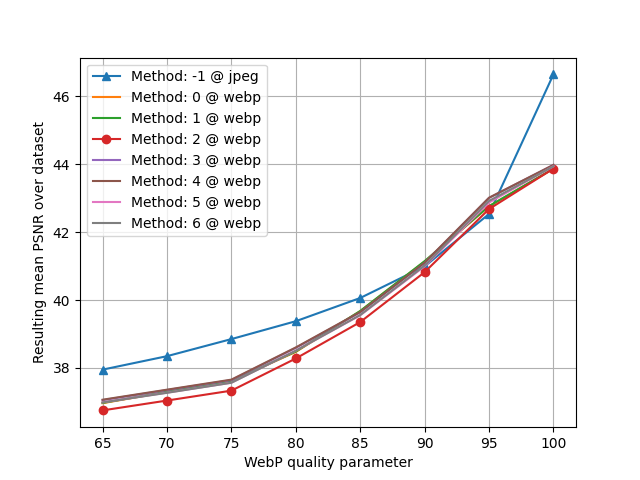

<IPython.core.display.Javascript object>


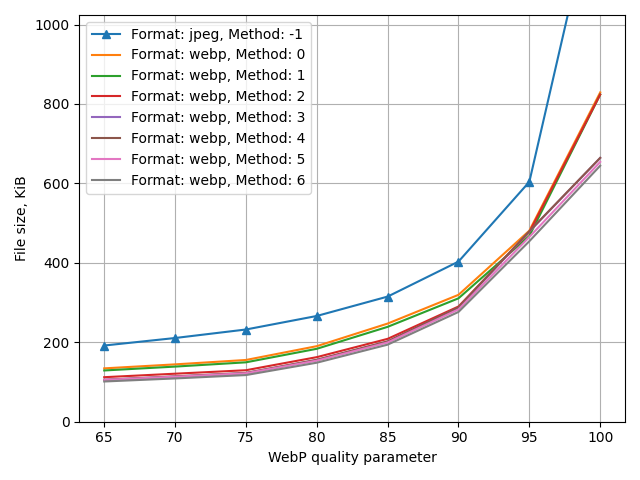

<IPython.core.display.Javascript object>


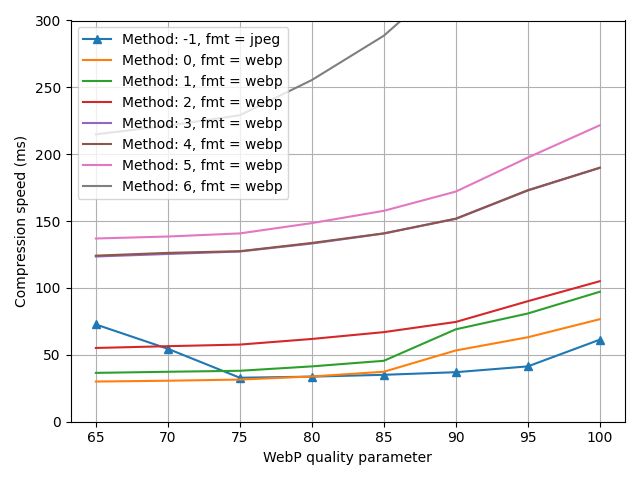

<IPython.core.display.Javascript object>


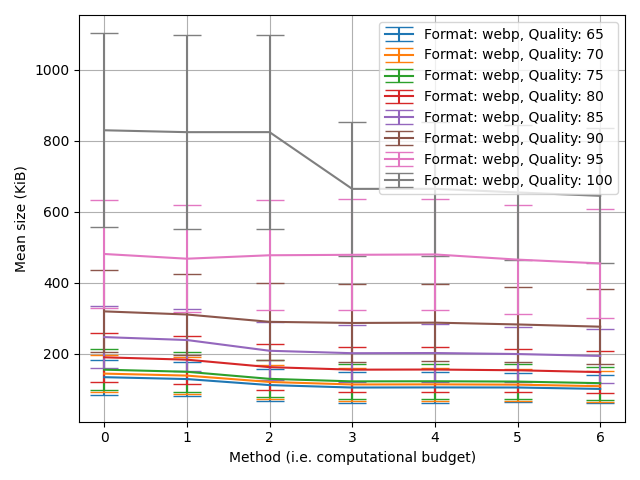

In [6]:
# Let's plot PSNR vs. quality (pretty predictible)
# 
# Box plots would be interesting in case there's some configs which cause unexpected spread
%matplotlib notebook
from collections import defaultdict

plot = defaultdict(lambda: defaultdict(dict))
size_plot = defaultdict(lambda: defaultdict(dict))
compression_speed_plot = defaultdict(lambda: defaultdict(dict))
decompression_speed_plot = defaultdict(lambda: defaultdict(dict))

# Buffer for timing metrics, ignore the first and last 'buffer' measurements
buffer = 3

# Track all fpaths even if redundant to make it easier to datamine and grab specific images, e.g.
# high filesize but low PSNR images (hard to compress).
all_fpaths = []
all_psnrs = []
all_sizes_b = []
all_qs = []
all_methods = []

for (fmt, quality, method), (fpaths, enc_t, dec_t, psnrs, ssims, sizes_b) in results.items():
    assert quality not in plot
    enc_t_b = enc_t[buffer:-buffer]
    dec_t_b = dec_t[buffer:-buffer]
    decompression_speed_plot[fmt][method][quality] = np.mean(dec_t_b), np.std(dec_t_b)
    compression_speed_plot[fmt][method][quality] = np.mean(enc_t_b), np.std(enc_t_b)
    
    plot[fmt][method][quality] = np.mean(psnrs), np.std(psnrs)
    size_plot[fmt][method][quality] = np.mean(sizes_b), np.std(sizes_b)

    all_fpaths += fpaths
    all_sizes_b += sizes_b
    all_psnrs += psnrs
    all_qs += [quality] * len(psnrs)
    all_methods += [method] * len(psnrs)
    
    
all_sizes_b = np.array(all_sizes_b)
all_psnrs = np.array(all_psnrs)
all_qs = np.array(all_qs)
all_methods = np.array(all_methods)
    
plt.figure()
for fmt in plot:
    for method in plot[fmt]:
        xx, yy, yerr = [], [], []
        for q, (mean_psnr, std) in plot[fmt][method].items():
            xx.append(q)
            yy.append(mean_psnr)
            yerr.append(std)

        label = f"Method: {method} @ {fmt}"
        m = '' if fmt == "webp" else "^"
        if method == 2:
            # For debug
            m = 'o'
    #     plt.errorbar(xx, yy, yerr=yerr, capsize=10, label=label)
        plt.plot(xx, yy, label=label, marker=m)
       


plt.xlabel("WebP quality parameter")
plt.ylabel("Resulting mean PSNR over dataset")
# plt.ylim(30, 50)
plt.legend()
plt.grid("on")

plt.figure()
for fmt in size_plot:
    for method in size_plot[fmt]:
        xx, yy, yerr = [], [], []
        for q, (mean_sz, std) in size_plot[fmt][method].items():
            xx.append(q)
            yy.append(mean_sz/1024)
            yerr.append(std/1024)
        label = f"Format: {fmt}, Method: {method}"
        m = '' if fmt == "webp" else "^"
    #     plt.errorbar(xx, yy, yerr=yerr, capsize=10, label=label)
        plt.plot(xx, yy, label=label, marker=m)
        
plt.xlabel("WebP quality parameter")
plt.ylabel("File size, KiB")
plt.ylim(0, 1024)
plt.legend()
plt.grid("on")
plt.tight_layout()


plt.figure()
for fmt in compression_speed_plot:
    for method in compression_speed_plot[fmt]:
        xx, yy, yerr = [], [], []
        for q, (mean_sz, std) in compression_speed_plot[fmt][method].items():
            xx.append(q)
            yy.append(mean_sz * 1000)
            yerr.append(std * 1000)
        label = f"Method: {method}, fmt = {fmt}"
        m = '' if fmt == "webp" else "^"
#         plt.errorbar(xx, yy, yerr=yerr, capsize=10, label=label, marker=m)
        plt.plot(xx, yy, label=label, marker=m)
        
plt.xlabel("WebP quality parameter")
plt.ylabel("Compression speed (ms)")

plt.ylim(0, 300)
plt.legend()
plt.grid("on")
plt.tight_layout()

#
# Space as a function of method (WebP-specific)
#
plt.figure()
for compression_level in size_plot["webp"][3]:
    for fmt in ["webp"]:
        xx, yy, yerr = [], [], []
        for method in size_plot[fmt]:
            mean_sz, std = size_plot[fmt][method][compression_level]
            xx.append(method)
            yy.append(mean_sz / 1024)
            yerr.append(std / 1024)

        label = f"Format: {fmt}, Quality: {compression_level}"
        plt.errorbar(xx, yy, yerr=yerr, capsize=10, label=label)

# TODO(andrei): Roughly map method to time factor (absolute difference depends on quality)
plt.xlabel("Method (i.e. computational budget)")
plt.ylabel("Mean size (KiB)")
plt.legend()
plt.grid("on")
plt.tight_layout()


<IPython.core.display.Javascript object>


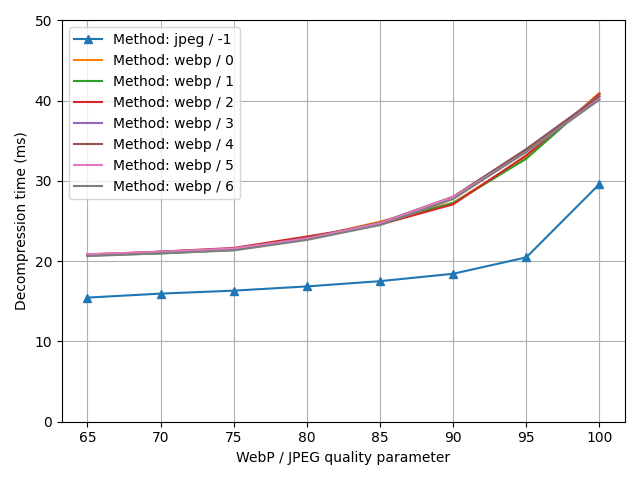

In [7]:

    
plt.figure()
for fmt in decompression_speed_plot:
    for method in decompression_speed_plot[fmt]:
        if fmt == "jpeg" and method != -1:
            continue
            
        xx, yy, yerr = [], [], []
        for q, (mean_sz, std) in decompression_speed_plot[fmt][method].items():
            xx.append(q)
            yy.append(mean_sz * 1000)
            yerr.append(std * 1000)
        label = f"Method: {fmt} / {method}"
#         plt.errorbar(xx, yy, yerr=yerr, capsize=10, label=label)
        m = '' if fmt == "webp" else "^"
        plt.plot(xx, yy, label=label, marker=m)
        
plt.xlabel("WebP / JPEG quality parameter")
plt.ylabel("Decompression time (ms)")

plt.ylim(0, 50)
plt.legend()
plt.grid("on")
plt.tight_layout()

In [ ]:
# Mean size for each PSNR bucket
psnr_bins = np.linspace(32, 45, num=10)

for q in [100, 95, 90, 85, 80]:
    foo = all_psnrs[(all_qs == q) & (all_methods == 3)]
    bar = all_sizes_b[(all_qs == q) & (all_methods == 3)]

    idxs = np.digitize(foo, psnr_bins)

    res = []
    res_std = []
    for bidx, bin in enumerate(psnr_bins):
        res.append(np.mean(bar[idxs == bidx]) / 1024)
        res_std.append(np.std(bar[idxs == bidx]) / 1024)

    plt.errorbar(psnr_bins, res, yerr=res_std, capsize=8, label=f"{q = }")
    
plt.legend()
plt.xlabel("PSNR")
plt.ylabel("Size (KiB)")
plt.ylim(0, 1024)

In [1]:
#
# PSNR vs. File Size
#
print(len(all_sizes_b))
print(len(all_psnrs))
c = all_qs
ax = plt.scatter(all_psnrs, np.array(all_sizes_b) / 1024, c=c, s=0.1) 
plt.colorbar(ax)
plt.ylim(0, 1024)
plt.xlabel("PSNR")
plt.ylabel("File Size (KiB)")
plt.title("Colored by WebP quality")

NameError: name 'all_sizes_b' is not defined

### Some conclusion
 - initial storage analysis used WebP method 4 at q=85
 - using JPEG at q85 would increase image space by 50% so we probably can't afford it :(
    - current estimate sits at roughly 160TiB conservatively.
    - images become ~50% of the storage if q=85 webp
    - if we increase image size by 50%, increase total storage by 25%, so ~200TiB, still within the 300TiB
    - jpeg at 90 means ~400k images, 100% increase in images, 50% total, so 240TiB, may be a little too much

 - for webp max compression use at least method = 2
 - for webp, method = 2 is an outlier in terms of PSNR... either use method = 3 or 0/1
     - of course 0/1 will produce larger files, but not by a lot 
     - prioritize PSNR over very tiny files!
 - method 3 and 4 are identical in compression speed!
 - method 2 is way faster than 3, ~2.3x faster
 - method 1 is is 3x faster than 3 ---> we should use '1'
     - storage of method 1 vs. JPEG: 307 --> 250kb, though JPEG PSNR at q=85 is higher
     
     
=> just do method=1 webp at q=90, instead of 2/4 at q=85.

# Detailed PSNR analysis

Maybe look at CDFs? Find outliers where there are huge PSNR gaps between methods?

In [ ]:
# Find outliers
high_file_low_psnr = (all_qs == 85) & (all_methods == 3) & (all_sizes_b > 600) & (all_psnrs < 40)
high_file_low_psnr.sum(), "matches"